# Plot oil spill simulation results

In [1]:
import glob
import os

import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

import rasterio
from rasterio.features import rasterize
from rasterio.enums import MergeAlg

import pyproj
import shapely
from shapely.ops import cascaded_union, unary_union
from shapely.geometry import LineString, Polygon, Point

import geopandas as gpd
import gdal

import cartopy

import distributed
from dask import delayed

In [2]:
class ParticleTrackingExperiment():
    """Static data about results from oil spill (ptrack) experiments"""
    ptrack_output_dir = ''
    ship_types = []

    # keys are ship_type, then dict of [month] = [ptrack files from that month]
    # {ship_type}{month} = [file1, file2, ... fileN]
    monthly_ptrack_files = {}
    # keys are ship_type, values are lists
    # {ship_type} = [values]
    ptrack_dirs = {}
    ptrack_files = {}

    def __init__(self, ptrack_output_dir, months=range(7, 12), include_ship_types=None):
        self.ptrack_output_dir = ptrack_output_dir
        self.load_ship_types(include_ship_types)
        self.load_ptrack_dirs()
        self.load_ptrack_files()
        self.load_monthly_ptrack_files(months)

    def load_ship_types(self, include_ship_types=None):
        """Return ship types based on output dirs, can filter by list of ship_types (include_ship_types)"""
        ship_dirs = [d for d in glob.glob(self.ptrack_output_dir + '/*') if os.path.isdir(d)]
        ship_types = [os.path.basename(sd) for sd in ship_dirs]
        if include_ship_types:
            ship_types = list(set(ship_types).intersection(include_ship_types))
        self.ship_types = ship_types

    def load_ptrack_dirs(self):
        """Return dict of paths to ptrack results for each shiptype"""
        for ship_type in self.ship_types:
            self.ptrack_dirs[ship_type] = os.path.join(self.ptrack_output_dir, '{}'.format(ship_type))

    def load_ptrack_files(self):
        """Return dict of list of ptrack results for each shiptype"""
        for ship_type in self.ship_types:
            ptfiles = glob.glob(self.ptrack_dirs[ship_type] + '/*.nc')
            ptfiles.sort()
            self.ptrack_files[ship_type] = ptfiles

    def bin_ptrack_files_into_months(self, ship_type, months):
        """Given a list of months (month integer) return a list of the ptrack output files separated by month"""
        return [f for f in self.ptrack_files[ship_type] if int(os.path.splitext(os.path.basename(f))[0].split('-')[-2]) in months]

    def load_monthly_ptrack_files(self, months):
        """Given a list of months (month integer) return a dict of lists of monthly ptrack files"""
        for ship_type in self.ship_types:
            self.monthly_ptrack_files[ship_type] = {}
            for month in months:
                monthly_files = [f for f in self.ptrack_files[ship_type] if int(os.path.splitext(os.path.basename(f))[0].split('-')[-2]) == month]
                self.monthly_ptrack_files[ship_type][month] = monthly_files

In [3]:
class ParticleTrackingResult():
    """Represent results from a single particle tracking experiment"""
    

    def __init__(self, fpath, bins, in_crs='epsg:4326', out_crs='epsg:3338'):
        self.fpath = fpath
        self.lon, self.lat = self._load_data()
        self.binned_results = self._bin_results(bins)
        
    def _load_data(self):
        """Loads the data during init"""
        with nc.Dataset(self.fpath) as ds:
            # only need the data with particles still in the water
            particles_in_water = ds.variables['status_codes'][:] == 2
            lon = ds.variables['longitude'][particles_in_water]
            lat = ds.variables['latitude'][particles_in_water]
        
        return lon, lat

    def _create_convex_hull(self):
        """Create convex hull from results"""
        # Load all points as a line string, then convert to polygon
        if len(self.lon) < 2:
            return None
        line = LineString(np.stack([self.lon, self.lat]).T)
        poly = Polygon(line)

        # Create a GeoDataFrame with geometry defined by polygon
        gdf_part = gpd.GeoDataFrame()
        gdf_part['geometry'] = None
        gdf_part.loc[0, 'geometry'] = poly

        # Return just the convex hull
        return gdf_part.convex_hull

    def intersects_region(self, region):
        """Given a Subsistence object return true if ParticleTrackingResults intersect"""
        self.convex_hull = self._create_convex_hull()
        intersects = False
        # only test is there are enough results sufficient to create a convex hull
        if self.convex_hull is not None:
            if region.boundary.intersects(self.convex_hull)[0]:
                intersects = True
        return intersects

    def _bin_results(self, bins, in_crs='epsg:4326', out_crs='epsg:3338'):
        """Given bins [x, y], return the binned ptrack results"""
        in_proj = pyproj.Proj(init=in_crs)
        out_proj = pyproj.Proj(init=out_crs)
        x, y = pyproj.transform(in_proj,
                                out_proj,
                                self.lon,
                                self.lat,
        )
        h, _, _ = np.histogram2d(x, y, bins=(bins.x, bins.y))
        
        # gotta rotate 90 to align with rasters correctly
        return np.rot90(h)

In [4]:
class RasterParams():
    """Parameters for rasters and plotting"""
    def __init__(self, params=None):
        if not params:
            params = {}

        # raster resolution
        self.pixel_size = params.get('pixel_size', 10000)

        # bounds of output grid in lat/lon
        self.output_min_lon = params.get('output_min_lon', -168)
        self.output_max_lon = params.get('output_max_lon', -141)
        self.output_min_lat = params.get('output_min_lat', 69)
        self.output_max_lat = params.get('output_max_lat', 73)

        # Lat/Lon CRS
        self.in_crs = params.get('in_crs', {'init': 'epsg:4326'})
        # Equal area projection
        self.out_crs = params.get('out_crs', {'init': 'epsg:3338'})

        # convert the bounding box to our output projection
        self.bounding_box = shapely.geometry.box(self.output_min_lon,
                                                 self.output_min_lat,
                                                 self.output_max_lon,
                                                 self.output_max_lat
        )
        bb_df = gpd.GeoDataFrame(crs=self.in_crs,
                                 geometry=[self.bounding_box]
        )
        self.bb_df = bb_df.to_crs(self.out_crs)

        self.x_min, self.y_min, self.x_max, self.y_max = self.bb_df.iloc[0].geometry.bounds
        self.x_res = int((self.x_max - self.x_min) / self.pixel_size)
        self.y_res = int((self.y_max - self.y_min) / self.pixel_size)

        # west, north, xsize, ysize
        self.transform = rasterio.transform.from_origin(self.x_min,
                                                        self.y_max,
                                                        self.pixel_size,
                                                        self.pixel_size
        )

        # map features
        self.crs = cartopy.crs.epsg(3338)
        self.land_10m = cartopy.feature.NaturalEarthFeature('physical',
                                                            'land',
                                                            '10m',
                                                            edgecolor='gray',
                                                            facecolor=cartopy.feature.COLORS['land']
        )
        self.profile = rasterio.profiles.Profile()
        self.profile.update({
            'driver': 'GTiff',
            'transform': self.transform,
            'width': self.x_res,
            'height': self.y_res,
            'crs': rasterio.crs.CRS.from_epsg(3338),
            'count': 1,
            'nodata': 0,
            'dtype': 'float32',
            'interleave': 'band',
            'tiled': False
        })

        self.raster_shape = (43, 108)

In [5]:
class Index():
    """Oil Spil Risk related index (array)"""
    def __init__(self, output_dir, raster_params=None):
        self.output_dir = output_dir
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        if raster_params:
            self.raster_params = raster_params
        else:
            self.raster_params = RasterParams()

        self.data = None

    def save_array(self, fname):
        """Save data to a .npy file"""
        output_file = os.path.join(self.output_dir, fname)
        np.save(output_file, self.data)

    def save_geotif(self, fname, profile=None):
        """Save data to a .geotif file"""
        if not profile:
            profile = self.raster_params.profile

        output_file = os.path.join(self.output_dir, fname)
        with rasterio.open(output_file, 'w', **profile) as dst:
            dst.write(self.data.astype('float32'), 1)

    def save_plot(self, fname, title, figsize=(18, 15), vmax=5000, cmap=plt.get_cmap('OrRd', 10)):
        """Create and save a plot of the data"""
        fig = plt.figure(figsize=figsize)
        ax = plt.axes(projection=self.raster_params.crs)
        ax.set_title(title, fontsize=20)
        ax.set_xmargin(0.05)
        ax.set_ymargin(0.10)
        ax.gridlines(zorder=0, color='lightgray')
        ax.add_feature(self.raster_params.land_10m)

        # mask out where we have no ship tracks (value=0)
        ma_mapped = np.ma.masked_where(self.data == 0, self.data)

        cax = ax.imshow(ma_mapped,
                        origin='upper',
                        extent=[self.raster_params.x_min,
                                self.raster_params.x_max,
                                self.raster_params.y_min,
                                self.raster_params.y_max
                                ],
                        transform=self.raster_params.crs,
                        interpolation='nearest',
                        vmin=0,
                        vmax=vmax,
                        cmap=cmap
                       )
        fig.colorbar(cax, orientation='horizontal')
        plt.tight_layout()

        output_file = os.path.join(self.output_dir, fname)
        plt.savefig(output_file, dpi=300)
        plt.close()

In [6]:
class SubsistenceRegion():
    """Represent a single subsistence region"""

    def __init__(self, fpath):
        self.fpath = fpath
        self.name = self._get_name()
        self.region, self.boundary = self.create_region_boundary()

    def _get_name(self):
        if 'Geodataframe' in self.fpath:
            name = os.path.basename(self.fpath).split('.')[0].split('_')[0].lower()
        else:
            name = os.path.basename(self.fpath).split('.')[0]
        return name

    def create_region_boundary(self):
        """Given a shape file, return the boundary"""
        if os.path.splitext(self.fpath)[1] == '.shp':
            region = gpd.read_file(self.fpath)
        else:
            region = gpd.read_file(self.fpath)

        # Since we are doing intersection with particles, we need this in lat-lon
        region_ll = region.to_crs({'init': 'epsg:4326'})

        # Creates a single geometry of the subsistence information
        # - this labels every entry as the same object
        region_ll['OBJECTID'] = 1

        # - join every object together to create the boundary of the subsistence area
        boundary = gpd.GeoSeries(cascaded_union(region_ll.geometry))

        return region, boundary

In [7]:
class ShipData():
    """Static data about ships from AIS derived heat maps"""

    # keys are ship_type, values are dicts with entry for each month
    months_ships_present = {}
    monthly_ship_count = {}
    monthly_ship_density_files = {}

    def __init__(self, ship_density_dir, ship_types):
        self.ship_density_dir = ship_density_dir
        self.ship_types = ship_types
        self.load_monthly_ship_data()

    def get_paths_to_monthly_ship_density_files(self, ship_type):
        """Given path to ship density outputs, return paths to monthly files"""
        return sorted(glob.glob('{}/*{}*.tif'.format(self.ship_density_dir, ship_type)))

    def get_months_ships_present(self, monthly_shipcounts):
        """Given list of monthly shipcounts, return list of months where those ships were present"""
        months = [int(os.path.splitext(os.path.basename(f))[0].split('-')[-1]) for f in monthly_shipcounts]
        return months

    def get_ship_count(self, ship_type, month):
        """Given ship type and month (int) return shipcount array"""
        fname = os.path.join(self.ship_density_dir, 'shipcount-{0}-{1:02d}.tif')
        ds = gdal.Open(fname.format(ship_type, int(month)))
        shipcount = np.array(ds.GetRasterBand(1).ReadAsArray())
        del ds
        return shipcount

    def load_monthly_ship_data(self):
        """Get ship data"""
        for ship_type in self.ship_types:
            self.monthly_ship_density_files[ship_type] = self.get_paths_to_monthly_ship_density_files(ship_type)
            self.months_ships_present[ship_type] = self.get_months_ships_present(self.monthly_ship_density_files[ship_type])
            self.monthly_ship_count[ship_type] = {month: self.get_ship_count(ship_type, month) for month in self.months_ships_present[ship_type]}

In [8]:
class RasterBins():
    def __init__(self, fpath):
        self.fpath = fpath
        self.x, self.y = self.calc_world_coords()

    def calc_world_coords(self):
        with rasterio.open(self.fpath) as ds:
            T0 = ds.transform
            # Translate the reference from pixel corner to center of pixel
            T1 = T0 * ds.transform.translation(0.5, 0.5)

            x = np.array([((col, 0)*T1)[0] for col in range(ds.shape[1])])
            x.sort()
            # add another bin at end so resulting shape matches
            dx = np.diff(x)[0]
            last_x = x[-1] + dx
            x = np.append(x, last_x)

            y = np.array([((0, row)*T0)[1] for row in range(ds.shape[0])])
            y.sort()
            dy = np.diff(y)[0]
            last_y = y[-1] + dy
            y = np.append(y, last_y)

            return x, y

In [9]:
ship_types = ['anti-pollution',
              'cargo',
              'icebreaker',
              'landing',
              'offshoresupply',
              'passenger',
              'recreational',
              'survey',
              'tanker',
              'tugboat'
            ]
ship_data = ShipData('/data/assets/arctic-osra/analysis_inputs/ship-density/', ship_types)

In [10]:
%%time
ptrack_experiment = ParticleTrackingExperiment('/data/assets/arctic-osra/2017_spills/ptrack_results/')

CPU times: user 2.79 s, sys: 188 ms, total: 2.98 s
Wall time: 28.9 s


In [11]:
%%time
regions_dir = '/data/assets/arctic-osra/analysis_inputs/subsistence_files/'
subsistence_tif_dir = '/data/assets/arctic-osra/analysis_inputs/subsistence_tifs/'
regions = [SubsistenceRegion(f) for f in glob.glob(regions_dir + '/*.geojson')]
sub_tifs = glob.glob(subsistence_tif_dir + '/*.tif')

CPU times: user 20.5 s, sys: 20 ms, total: 20.5 s
Wall time: 21 s


In [12]:
%%time
bins = RasterBins(sub_tifs[0])

CPU times: user 12 ms, sys: 8 ms, total: 20 ms
Wall time: 91.5 ms


In [16]:
# let's use dask!

In [17]:
client = distributed.Client('aracuaria.ib.axiomptk:8786')

In [19]:
@delayed
def agg(x, y):
    return x + y


def bfs_merge(seq):
    if len(seq) < 2:
        return seq
    middle = len(seq) // 2
    left = bfs_merge(seq[:middle])
    right = bfs_merge(seq[middle:])
    if not right:
        return left
    return [agg(left[0], right[0])]

def dfs_merge(seq):
    if len(seq) < 2:
        return seq
 

In [20]:
def get_bin(fname, bins=bins):
    ptrack_result = ParticleTrackingResult(fname, bins)
    return ptrack_result.binned_results

In [21]:
def make_plot(spill_index, fname, ship_type, month):
    """Given summed up data (all_done) save the figure"""
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=spill_index.raster_params.crs)
    ax.set_title('{0} - {1:02d}'.format(ship_type, month), fontsize=20)
    ax.set_xmargin(0.05)
    ax.set_ymargin(0.10)
    ax.gridlines(zorder=0, color='lightgray')
    ax.add_feature(spill_index.raster_params.land_10m)

    # mask out where we have no ship tracks (value=0)
    ma_mapped = np.ma.masked_where(spill_index.data == 0, spill_index.data)
    #ma_mapped /= np.nanmax(ma_mapped)

    cax = ax.imshow(ma_mapped,
                    origin='upper',
                    transform=spill_index.raster_params.crs,
                    extent=[spill_index.raster_params.x_min,
                            spill_index.raster_params.x_max,
                            spill_index.raster_params.y_min,
                            spill_index.raster_params.y_max
                            ],
                    vmin=0,
                    vmax=None,
                    interpolation='nearest',
                    cmap=plt.get_cmap('magma_r', 10)
                    )

    fig.colorbar(cax, orientation='horizontal')
    # doens't work for this dataset???
    #plt.tight_layout()

    output_file = os.path.join(spill_index.output_dir, fname)
    plt.savefig(output_file, dpi=300)
    #plt.close()
    plt.show()

In [22]:
def save_geotif(spill_index, fname, profile=None):
    """Save data to a .geotif file"""
    if not profile:
        profile = spill_index.raster_params.profile

    output_file = os.path.join(spill_index.output_dir, fname)
    with rasterio.open(output_file, 'w', **profile) as dst:
        dst.write(spill_index.data.astype('float32'), 1)

/opt/conda/envs/py35/lib/python3.5/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/physical/ne_10m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


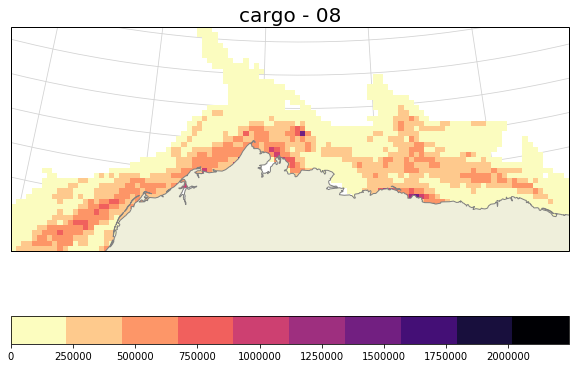

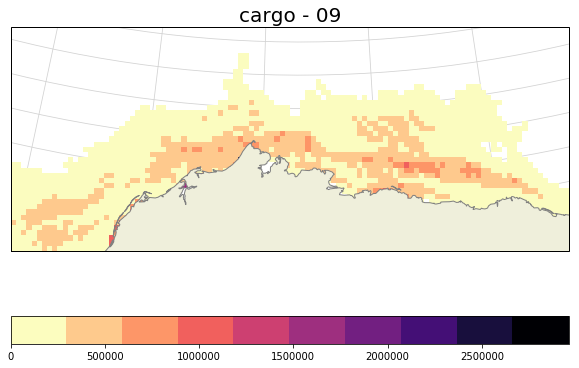

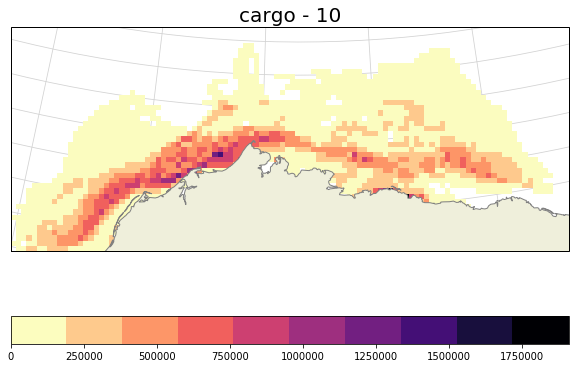

error: cargo 11
error: icebreaker 6


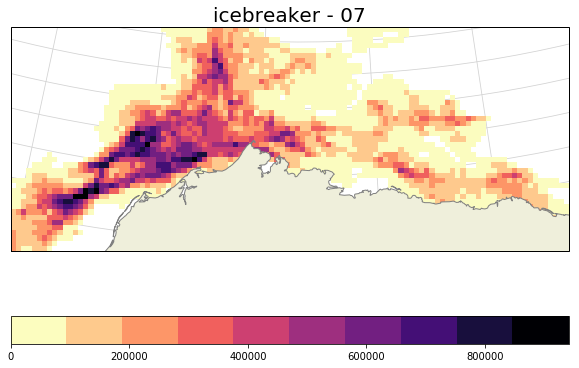

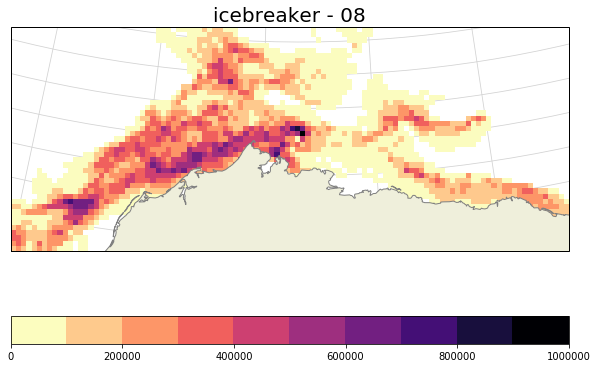

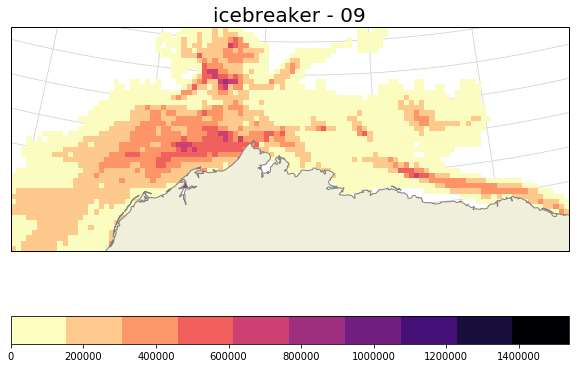

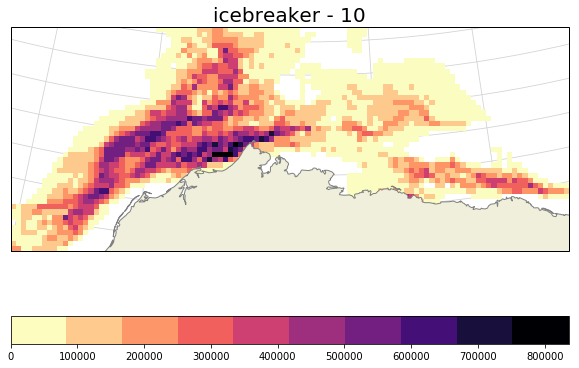

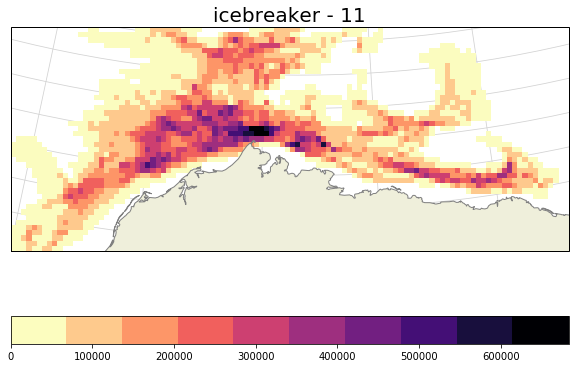

error: icebreaker 12


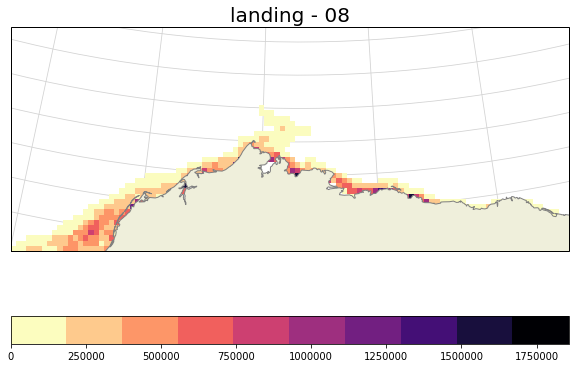

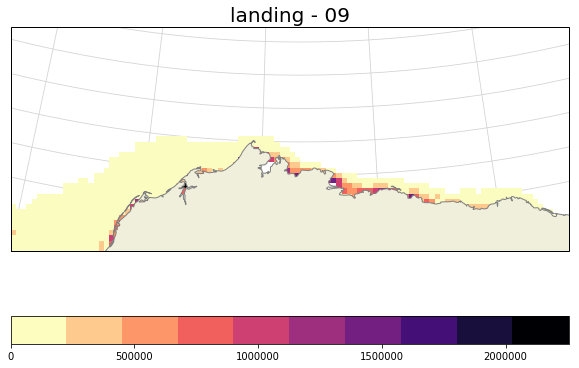

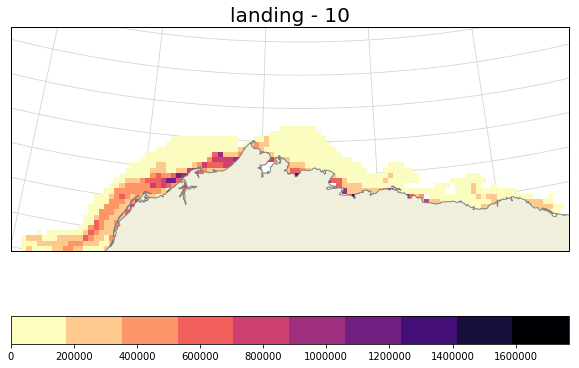

error: landing 11


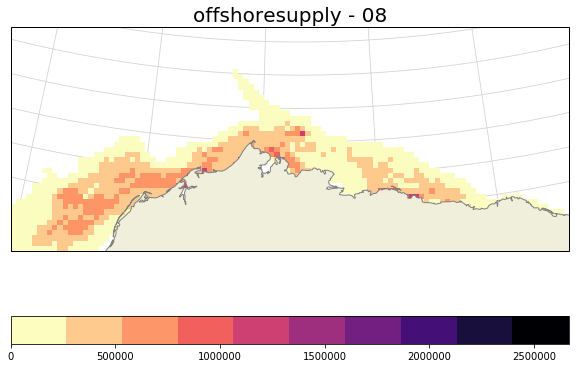

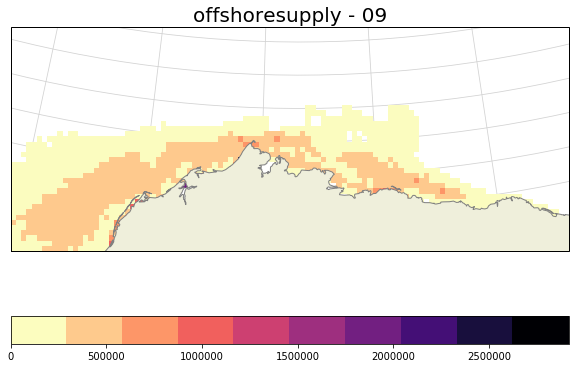

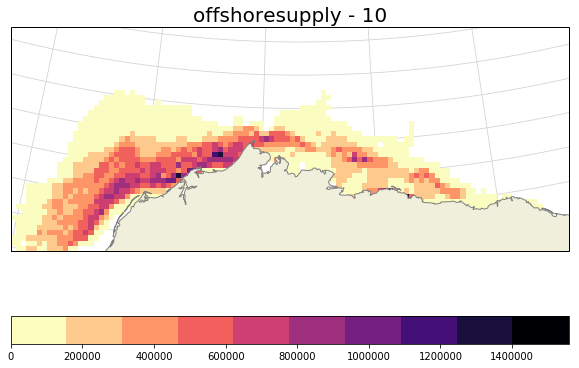

error: offshoresupply 11
error: passenger 6


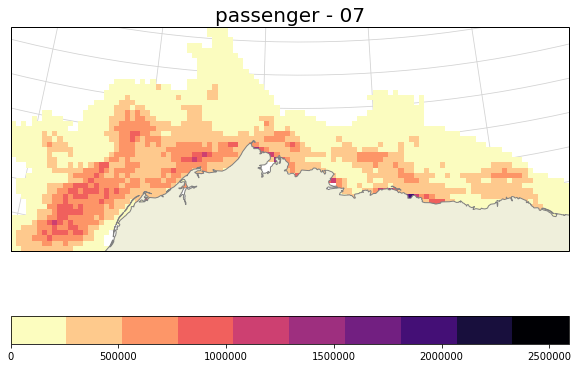

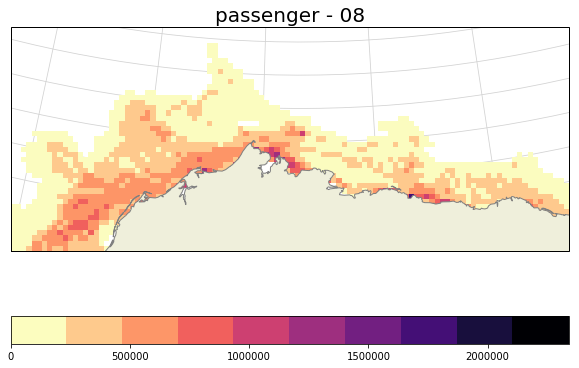

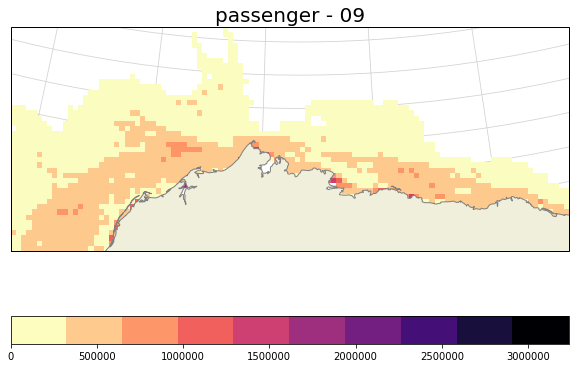

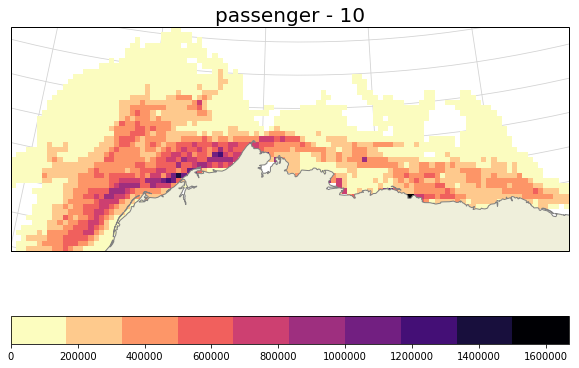

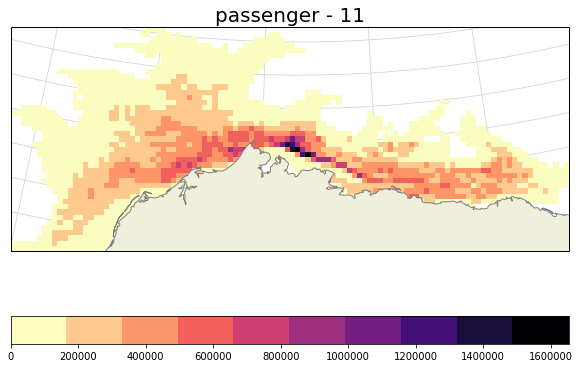

error: passenger 12
error: recreational 7
error: recreational 9
error: recreational 10


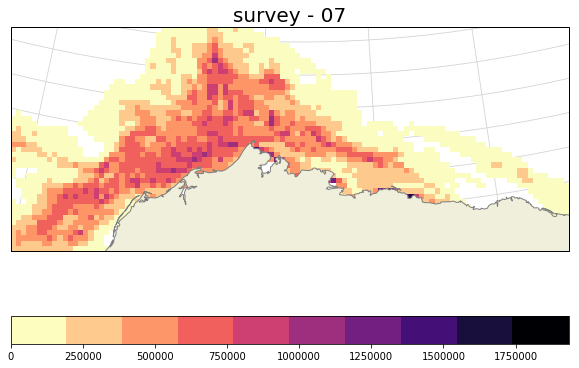

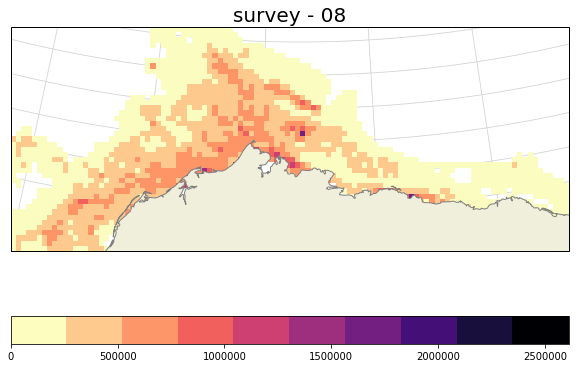

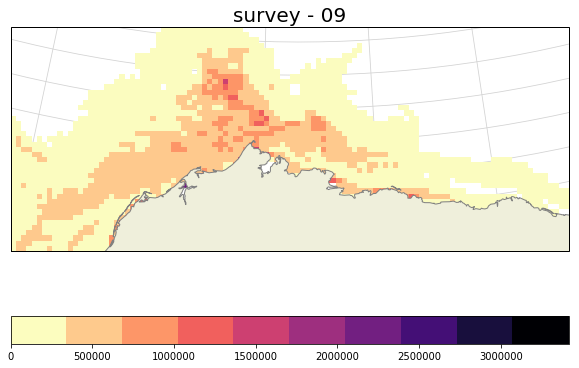

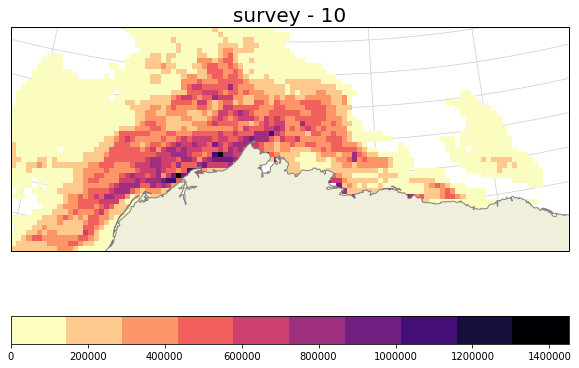

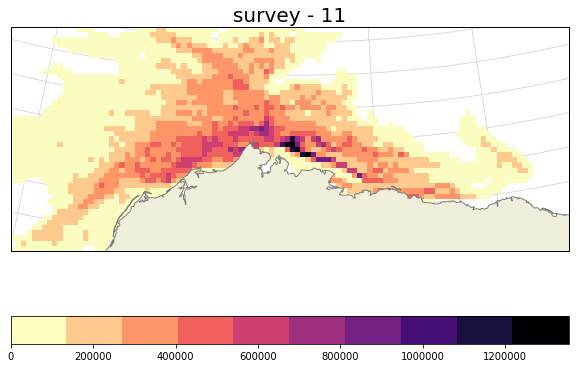

error: survey 12


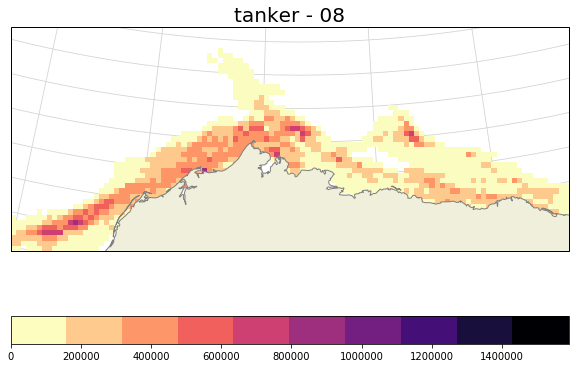

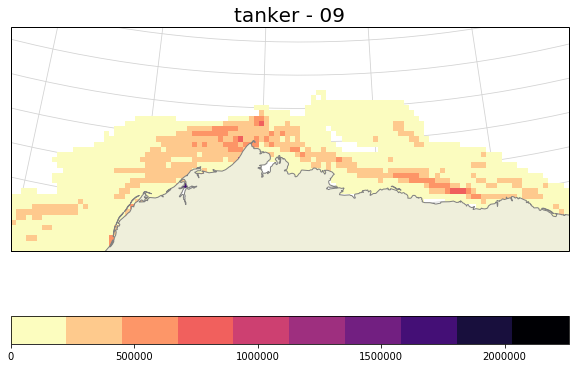

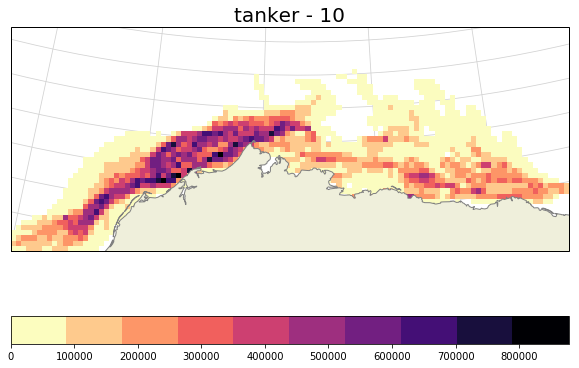

error: tanker 11


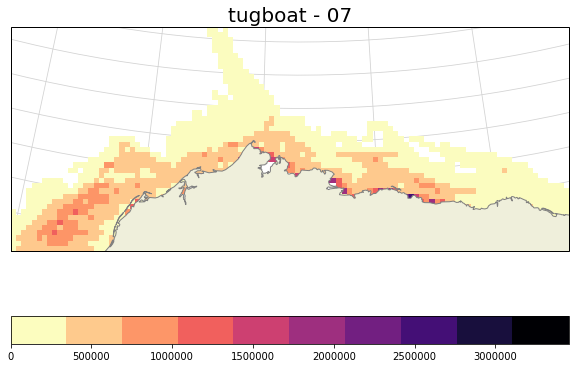

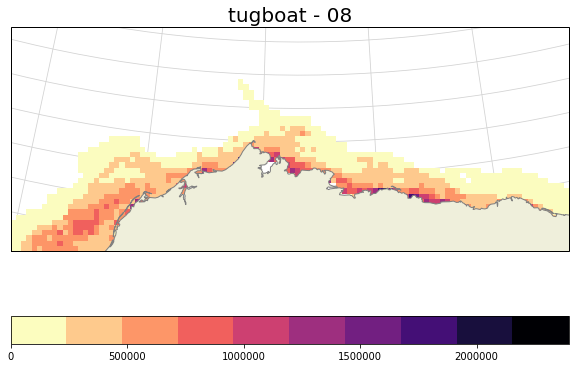

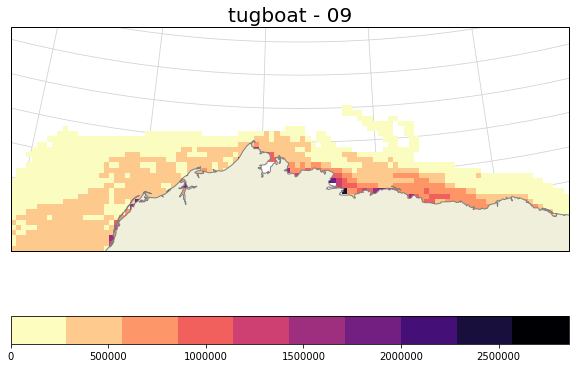

In [ ]:
%%time
spill_index = Index('../../outputs/OSRA/spill-results/')
for ship_type in ship_data.ship_types[1::]:
    for month in ship_data.months_ships_present[ship_type]:
        try:
            results_files = ptrack_experiment.monthly_ptrack_files[ship_type][month]
            ptrack_futures = client.map(get_bin, results_files, bins=bins)
            reduced_sum = bfs_merge(ptrack_futures)[0]
            spill_index.data = reduced_sum.compute()
        
            fname = 'is-{0}-{1:02d}.npy'.format(ship_type, month)
            spill_index.save_array(fname)
            fname = 'is-{0}-{1:02d}.tif'.format(ship_type, month)
            spill_index.save_geotif(fname)
            fname = 'is-{0}-{1:02d}.png'.format(ship_type, month)
            make_plot(spill_index, fname, ship_type, month)
        except IndexError:
            print('error: {} {}'.format(ship_type, month))
            continue
        except KeyError:
            print('error: {} {}'.format(ship_type, month))
            continue